In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sn
from sklearn.cluster import KMeans
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import statsmodels.api as sm
from sklearn import model_selection
import copy
import math
from sklearn.metrics import confusion_matrix

In [3]:
sub_df = pd.read_pickle('subscribers')
cust_rep_df = pd.read_pickle('customer_service_reps')
engage_df = pd.read_pickle('engagement')

## Data Pre-processing

In [4]:
sub_df.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0,0.0367,ar,False,False,NaN


In [5]:
sub_df.shape

(227628, 29)

In [6]:
na_num = sub_df.isna().sum()
na_ratio = na_num / len(sub_df)
na_ratio.sort_values(ascending=False).to_excel('null_ratio.xlsx')

In [7]:
sub_df['age']

162502     NaN
380374    70.0
496617    25.0
356799    30.0
681701    28.0
          ... 
509326    38.0
229587    49.0
281340    45.0
87198      NaN
598241    55.0
Name: age, Length: 227628, dtype: float64

In [9]:
sub_df['intended_use'].value_counts()

access to exclusive content    89039
replace OTT                    69185
supplement OTT                 26603
expand regional access         14025
expand international access    12978
other                           7112
education                       5137
Name: intended_use, dtype: int64

In [11]:
sub_df['plan_type'].value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
base_uae_no_trial_7_day_guarantee         1
high_jpy_14_day_trial                     1
low_eur_no_trial                          1
low_sar_no_trial                          1
Name: plan_type, dtype: int64

In [12]:
# Demographic
demo_list = ['age','male_TF','preferred_genre',
             'package_type']

# Behavirol
behave_list = ['weekly_consumption_hour','num_weekly_services_utilized','op_sys']

# Plan
plan_list = ['months_per_bill_period','monthly_price','discount_price',
             'account_creation_date', 'creation_until_cancel_days',
             'cancel_before_trial_end', 'trial_end_date',
              'paid_TF','refund_after_trial_TF','join_fee','plan_type']


# Preference
prefer_list = ['num_ideal_streaming_services','retarget_TF','initial_credit_card_declined',
              'payment_type','intended_use']

# Attribution
attribute_list = ['attribution_technical','attribution_survey','revenue_net']

# Geographical
geo_list = ['country','language']

test_list = demo_list+behave_list+prefer_list+attribute_list+geo_list+plan_list

set(test_list1).difference(set(test_list))


{'subid'}

In [14]:
cust_rep_df.head()

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN


In [15]:
engage_df.head()

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0


## Customer Segmentation

### Clean outliers

In [16]:
# Age outliers cleaning

sub_df['age'].describe

Q = sub_df['age'].quantile(0.99)
# Q is 78

q = sub_df['age'].quantile(0.01)
# q is 20 


sub_df.loc[sub_df['age'] > 100,'age'] = random.randint(Q,100)
sub_df.loc[sub_df['age'] < q,'age'] = random.randint(14,q)
random.seed = 3
sub_df['age']=round(sub_df['age'])
random.seed = 3

In [17]:
# Weekly consumption hour clearning

# If weekly consumption hour < 0
# The weekly consumption hour should be set to 0 
sub_df.loc[sub_df['weekly_consumption_hour'] < 0,'weekly_consumption_hour'] = 0

### Clean null values

In [18]:
# Drop rows that male_TF is null
# Only 0.1% people did not report gender
# segment_df = sub_df.dropna(subset=['male_TF'])
# segment_df = segment_df.drop(segment_df[segment_df['join_fee'] < 0].index)
# segment_df

In [19]:
segment_df = sub_df[demo_list+behave_list+['subid']]

# Drop rows that male_TF is null
# Only 0.1% people did not report gender

segment_df = segment_df.dropna(subset=['male_TF'])


segment_df = segment_df.dropna(subset=['preferred_genre'])


In [20]:
# age null value
segment_df['age'] = segment_df['age'].interpolate()
# segment_df = segment_df.dropna(subset=['age'])
# segment_df['age'].fillna(method='ffill', inplace=True)

# weekly consumption null value

segment_df['weekly_consumption_hour'] = segment_df['weekly_consumption_hour'].interpolate()

# weekly consumption null value

segment_df['num_weekly_services_utilized'].interpolate(inplace = True)

In [21]:
pd.isnull(segment_df['num_weekly_services_utilized']).values.any()

True

In [22]:
segment_df.columns

Index(['age', 'male_TF', 'preferred_genre', 'package_type',
       'weekly_consumption_hour', 'num_weekly_services_utilized', 'op_sys',
       'subid'],
      dtype='object')

In [23]:
na_num = segment_df.isna().sum()
na_ratio = na_num / len(sub_df)
na_ratio.sort_values(ascending=False)

op_sys                          0.048232
package_type                    0.000347
num_weekly_services_utilized    0.000009
age                             0.000004
weekly_consumption_hour         0.000004
male_TF                         0.000000
preferred_genre                 0.000000
subid                           0.000000
dtype: float64

In [24]:
segment_df.dropna(inplace=True)

In [25]:
segment_df['age'].value_counts()

50.000000    4562
40.000000    4422
48.000000    4154
49.000000    4029
47.000000    3988
             ... 
49.142857       1
29.400000       1
45.285714       1
66.285714       1
74.666667       1
Name: age, Length: 683, dtype: int64

In [26]:
# null value tester

na_num = segment_df.isna().sum()
na_ratio = na_num / len(sub_df)
na_ratio.sort_values(ascending=False)

age                             0.0
male_TF                         0.0
preferred_genre                 0.0
package_type                    0.0
weekly_consumption_hour         0.0
num_weekly_services_utilized    0.0
op_sys                          0.0
subid                           0.0
dtype: float64

In [27]:
segment_df

,age,male_TF,preferred_genre,package_type,weekly_consumption_hour,num_weekly_services_utilized,op_sys,subid
496617,25.0,True,regional,enhanced,36.001186,3.362885,iOS,26844789
356799,30.0,False,drama,base,20.051667,3.546987,Android,29417030
681701,28.0,False,comedy,base,22.951579,3.731089,iOS,26723159
192823,61.0,False,comedy,base,20.051667,2.049135,Android,29726122
315863,23.0,False,drama,base,34.551230,3.002048,iOS,20299962
...,...,...,...,...,...,...,...,...
509326,38.0,False,comedy,enhanced,28.751405,2.594078,iOS,21434712
229587,49.0,False,comedy,enhanced,27.301448,2.361370,iOS,25843074
281340,45.0,False,comedy,base,31.651317,2.361370,iOS,24799085
87198,50.0,False,comedy,base,28.751405,2.361370,iOS,21308040


In [28]:
# turn True & False into 1 & 0

segment_df['male_TF'] = segment_df['male_TF'].astype(int)

In [29]:
segment_df_dummy = pd.get_dummies(segment_df,
    columns=[ 'preferred_genre', 'package_type','op_sys'],
    prefix=[ 'genre_is', 'package_is','op_is'])

In [30]:
segment_df_dummy

,age,male_TF,weekly_consumption_hour,num_weekly_services_utilized,subid,genre_is_comedy,genre_is_drama,genre_is_international,genre_is_other,genre_is_regional,package_is_base,package_is_economy,package_is_enhanced,op_is_Android,op_is_iOS
496617,25.0,1,36.001186,3.362885,26844789,0,0,0,0,1,0,0,1,0,1
356799,30.0,0,20.051667,3.546987,29417030,0,1,0,0,0,1,0,0,1,0
681701,28.0,0,22.951579,3.731089,26723159,1,0,0,0,0,1,0,0,0,1
192823,61.0,0,20.051667,2.049135,29726122,1,0,0,0,0,1,0,0,1,0
315863,23.0,0,34.551230,3.002048,20299962,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,38.0,0,28.751405,2.594078,21434712,1,0,0,0,0,0,0,1,0,1
229587,49.0,0,27.301448,2.361370,25843074,1,0,0,0,0,0,0,1,0,1
281340,45.0,0,31.651317,2.361370,24799085,1,0,0,0,0,1,0,0,0,1
87198,50.0,0,28.751405,2.361370,21308040,1,0,0,0,0,1,0,0,0,1


### K-Means clustering

In [31]:
scaler = preprocessing.StandardScaler()

segment_df_dummy_scale_cols = pd.DataFrame(scaler.fit_transform(segment_df_dummy[['age','weekly_consumption_hour','num_weekly_services_utilized']])).rename(columns={0:'age_scale',1:'weekly_consumption_hour_scale',2:'num_weekly_services_utilized_scale'})

segment_df_dummy_reindex = segment_df_dummy.reset_index(drop=True)
segment_df_dummy_minmax = pd.concat([segment_df_dummy_scale_cols,segment_df_dummy_reindex],axis=1)
segment_df_dummy_minmax.drop(columns=['age','weekly_consumption_hour','num_weekly_services_utilized'],inplace=True)

In [32]:
segment_df_dummy_minmax

,age_scale,weekly_consumption_hour_scale,num_weekly_services_utilized_scale,male_TF,subid,genre_is_comedy,genre_is_drama,genre_is_international,genre_is_other,genre_is_regional,package_is_base,package_is_economy,package_is_enhanced,op_is_Android,op_is_iOS
0,-1.552623,1.693313,0.540913,1,26844789,0,0,0,0,1,0,0,1,0,1
1,-1.179716,-1.706660,0.816544,0,29417030,0,1,0,0,0,1,0,0,1,0
2,-1.328879,-1.088484,1.092175,0,26723159,1,0,0,0,0,1,0,0,0,1
3,1.132308,-1.706660,-1.425987,0,29726122,1,0,0,0,0,1,0,0,1,0
4,-1.701786,1.384224,0.000681,0,20299962,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180005,-0.583065,0.147870,-0.610118,0,21434712,1,0,0,0,0,0,0,1,0,1
180006,0.237331,-0.161218,-0.958519,0,25843074,1,0,0,0,0,0,0,1,0,1
180007,-0.060995,0.766047,-0.958519,0,24799085,1,0,0,0,0,1,0,0,0,1
180008,0.311912,0.147870,-0.958519,0,21308040,1,0,0,0,0,1,0,0,0,1


In [33]:
segment_df_dummy_minmax

,age_scale,weekly_consumption_hour_scale,num_weekly_services_utilized_scale,male_TF,subid,genre_is_comedy,genre_is_drama,genre_is_international,genre_is_other,genre_is_regional,package_is_base,package_is_economy,package_is_enhanced,op_is_Android,op_is_iOS
0,-1.552623,1.693313,0.540913,1,26844789,0,0,0,0,1,0,0,1,0,1
1,-1.179716,-1.706660,0.816544,0,29417030,0,1,0,0,0,1,0,0,1,0
2,-1.328879,-1.088484,1.092175,0,26723159,1,0,0,0,0,1,0,0,0,1
3,1.132308,-1.706660,-1.425987,0,29726122,1,0,0,0,0,1,0,0,1,0
4,-1.701786,1.384224,0.000681,0,20299962,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180005,-0.583065,0.147870,-0.610118,0,21434712,1,0,0,0,0,0,0,1,0,1
180006,0.237331,-0.161218,-0.958519,0,25843074,1,0,0,0,0,0,0,1,0,1
180007,-0.060995,0.766047,-0.958519,0,24799085,1,0,0,0,0,1,0,0,0,1
180008,0.311912,0.147870,-0.958519,0,21308040,1,0,0,0,0,1,0,0,0,1


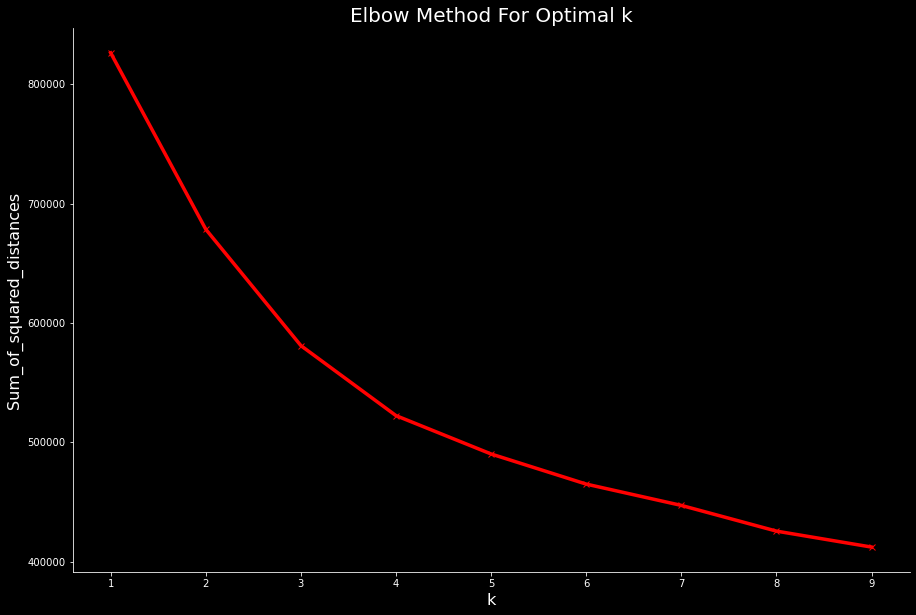

In [95]:
def fitting(data):
    Sum_of_squared_distances = []
    K = range(1,10)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
        
    plt.style.use('dark_background')
    plt.figure(figsize=(15, 10))
    plt.plot(K, Sum_of_squared_distances, 'bx-',color='red',lw=3.5)
    ax = plt.gca() # 获取当前的axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    plt.xlabel('k',fontdict={'size': 16})
    plt.ylabel('Sum_of_squared_distances',fontdict={'size': 16})
    
    plt.title('Elbow Method For Optimal k',fontdict={'size': 20})
    plt.savefig('elbow.png',transparent = True)
    plt.show()

    return 

fitting(segment_df_dummy_minmax.drop(columns=['subid']))

In [35]:
# add clusters into the data table

kmeans3 = KMeans(n_clusters=3, random_state=9).fit(segment_df_dummy_minmax.reset_index(drop=True).drop(columns=['subid']))

km_label = pd.DataFrame(kmeans3.labels_,columns=['cluster'])
# km_label = list(kmeans3.labels_)
# segment_df_dummy['cluster'] = km_label
segment_df_km = pd.concat([segment_df_dummy.drop(columns=['subid']).reset_index(drop=True),km_label],axis=1)

In [36]:
segment_summary = segment_df_km.groupby('cluster')
segment_summary.mean().T.to_excel('segment_summary.xlsx')

In [37]:
segment_summary.mean().T

cluster,0,1,2
age,45.058602,34.821991,57.943239
male_TF,0.355705,0.042965,0.048780
weekly_consumption_hour,32.815206,26.755875,26.476954
num_weekly_services_utilized,3.808938,2.720369,2.797236
genre_is_comedy,0.567557,0.733635,0.642371
genre_is_drama,0.300587,0.171803,0.271377
genre_is_international,0.051359,0.017447,0.034343
genre_is_other,0.024159,0.018291,0.020993
genre_is_regional,0.056339,0.058824,0.030916
package_is_base,0.570813,0.529060,0.643235


## Attribution and Allocation

In [38]:
sub_df['account_creation_date']

162502   2020-01-24 21:44:16
380374   2020-03-01 15:44:35
496617   2019-12-07 16:37:06
356799   2020-01-27 16:09:32
681701   2019-10-05 12:57:07
                 ...        
509326   2019-11-17 14:12:33
229587   2019-12-06 18:02:13
281340   2019-12-21 19:40:44
87198    2020-01-17 23:58:51
598241   2019-11-26 19:09:09
Name: account_creation_date, Length: 227628, dtype: datetime64[ns]

In [39]:
sub_df['account_creation_date'] = sub_df['account_creation_date'].apply(lambda x: datetime.strftime(x, "%Y-%m"))

In [40]:
people_series = sub_df[['account_creation_date','attribution_technical']].value_counts()

In [41]:
people_num_df = sub_df[['account_creation_date','attribution_technical']].value_counts().to_frame()

In [42]:
people_num_df = people_num_df.reset_index()

In [43]:
people_num_df = people_num_df.rename(columns={0:'num_people','account_creation_date':'date'})

In [44]:
people_num_df = people_num_df.pivot(columns='attribution_technical',index = 'date',values='num_people').reset_index()

In [45]:
spend_df = pd.read_excel('advertising_spend_data.xlsx')

In [46]:
spend_df

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019-06-30,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07-31,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08-31,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09-30,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10-31,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11-30,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12-31,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01-31,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02-29,49700,76600,30100,21700,15000,300,6400,6500
9,2020-03-31,49100,78000,22700,21200,17600,300,5900,10000


In [47]:
spend_df['date'] = spend_df['date'].apply(lambda x: datetime.strftime(x, "%Y-%m"))

In [48]:
spend_df = spend_df.iloc[0:9,:]

In [49]:
spend_df

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019-06,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02,49700,76600,30100,21700,15000,300,6400,6500


In [50]:
spend_df.iloc[:,1:].sum()

facebook                   503600
email                      682600
search                     209800
brand sem intent google    194900
affiliate                  121900
email_blast                226100
pinterest                   57400
referral                    63400
dtype: int64

In [51]:
# extract the column from spend data

spend_list = spend_df.columns.to_list()

In [52]:
people_num_df = people_num_df[spend_list].iloc[1:,]

In [53]:
people_num_df.iloc[:,1:]

attribution_technical,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
1,10011.0,3260.0,1328.0,2090.0,839.0,1510.0,793.0,528.0
2,9855.0,3092.0,1939.0,1895.0,1903.0,1902.0,637.0,521.0
3,6129.0,2420.0,1852.0,1530.0,1065.0,1582.0,517.0,582.0
4,9489.0,2305.0,2333.0,1602.0,760.0,977.0,682.0,529.0
5,12995.0,2584.0,2510.0,2030.0,509.0,629.0,594.0,587.0
6,9288.0,2677.0,3770.0,2443.0,565.0,411.0,851.0,666.0
7,6289.0,2368.0,4073.0,2626.0,1074.0,35.0,819.0,584.0
8,7988.0,3168.0,4300.0,2346.0,1480.0,66.0,680.0,583.0
9,6889.0,3507.0,3093.0,1765.0,1621.0,56.0,455.0,568.0


In [54]:
people_num_df.iloc[:,1:].sum()

attribution_technical
facebook                   78933.0
email                      25381.0
search                     25198.0
brand sem intent google    18327.0
affiliate                   9816.0
email_blast                 7168.0
pinterest                   6028.0
referral                    5148.0
dtype: float64

In [96]:
result = spend_df.iloc[:,1:].sum().div(people_num_df.iloc[:,1:].sum())
result.to_excel('attribution.xlsx')

In [56]:
cac_df = spend_df.iloc[:,1:].div(people_num_df.iloc[:,1:])

In [57]:
cac_df.dropna()

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
1,5.993407,23.190184,13.027108,10.191388,14.302741,19.735099,7.566204,12.500000
2,5.306951,24.611902,9.334709,11.240106,8.565423,34.647739,9.733124,13.051823
3,7.994779,31.322314,10.205184,13.921569,15.399061,46.586599,11.605416,12.714777
4,5.406260,32.971800,9.001286,13.358302,16.052632,33.060389,9.824047,13.799622
5,4.317045,29.373065,8.525896,10.640394,22.986248,15.580286,10.606061,12.436116
6,5.534022,28.427344,8.514589,9.087188,21.415929,8.515815,8.460635,12.012012
7,7.791382,31.883446,8.249448,8.644326,13.314711,8.571429,8.180708,12.671233
8,6.221833,24.179293,7.000000,9.249787,10.135135,4.545455,9.411765,11.149228


## Churn

In [58]:
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [59]:
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

### inspect engagement

In [60]:
engage_df = engage_df.groupby('subid').sum()

In [61]:
engage_df

,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
subid,,,,,,,
20000062,4.0,3.0,6.0,23.0,0.0,1.0,0.0
20000405,5.0,4.0,13.0,17.0,0.0,1.0,0.0
20000604,14.0,5.0,8.0,68.0,0.0,1.0,2.0
20000685,46.0,10.0,14.0,165.0,0.0,8.0,25.0
20000741,1.0,1.0,2.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
29999740,15.0,3.0,11.0,31.0,0.0,0.0,0.0
29999820,12.0,6.0,22.0,50.0,0.0,7.0,0.0
29999822,5.0,4.0,2.0,25.0,0.0,1.0,0.0


In [62]:
cust_rep_df['current_sub_TF'].value_counts()

False    1390355
True      818288
Name: current_sub_TF, dtype: int64

In [63]:
cust_rep_df = cust_rep_df[['subid','current_sub_TF']].value_counts().to_frame().reset_index().drop(columns=[0])

In [64]:
cust_rep_df.loc[cust_rep_df['current_sub_TF'] == True,'churn_TF'] = 0
cust_rep_df.loc[cust_rep_df['current_sub_TF'] == False,'churn_TF'] = 1

In [65]:
# use segment df to build a churn df
# option 1: standard version
# option 2: before standard version

churn_df = segment_df_dummy.iloc[:,0:5]

In [66]:
# subid is the key to merge churn df and cust rep df

churn_df_merge = pd.merge(churn_df, cust_rep_df[['churn_TF','subid']],how = 'left', on = ['subid'])
churn_df_merge = pd.merge(churn_df_merge, engage_df,how = 'left', on = ['subid'])

In [67]:
churn_df_merge = churn_df_merge.dropna()

In [68]:
churn_df_merge['churn_TF'] = churn_df_merge['churn_TF'].astype(int)

In [69]:
churn_df_merge.columns

Index(['age', 'male_TF', 'weekly_consumption_hour',
       'num_weekly_services_utilized', 'subid', 'churn_TF', 'app_opens',
       'cust_service_mssgs', 'num_videos_completed',
       'num_videos_more_than_30_seconds', 'num_videos_rated',
       'num_series_started', 'payment_period'],
      dtype='object')

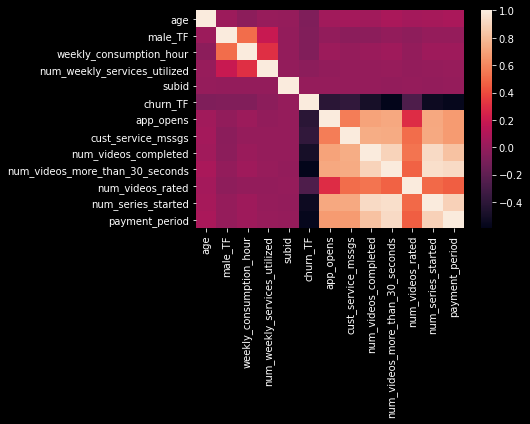

In [70]:
corr = churn_df_merge.corr()


# plt.figure(figsize=(16, 10))
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
sn.heatmap(corr)

plt.savefig("correlation.png")
plt.show()

In [71]:
churn_df_merge.head()

,age,male_TF,weekly_consumption_hour,num_weekly_services_utilized,subid,churn_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
0,25.0,1,36.001186,3.362885,26844789,1,2.0,2.0,13.0,13.0,0.0,1.0,0.0
3,61.0,0,20.051667,2.049135,29726122,0,40.0,17.0,182.0,182.0,6.0,39.0,31.0
4,23.0,0,34.551230,3.002048,20299962,0,104.0,10.0,84.0,206.0,0.0,29.0,31.0
5,73.0,0,25.851492,2.926198,24930568,1,3.0,3.0,2.0,13.0,0.0,0.0,0.0
7,24.0,1,37.451142,2.651517,21361112,1,4.0,3.0,2.0,12.0,0.0,0.0,0.0


In [72]:
churn_col_list = list(churn_df_merge.columns)

In [73]:
churn_col_list.remove('male_TF')

In [74]:
churn_col_list.remove('churn_TF')

In [75]:
churn_col_list.remove('subid')

In [76]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
# segment_df_dummy_minmax = segment_df_dummy
churn_df_merge[churn_col_list] = churn_df_merge[churn_col_list].apply(max_min_scaler)

In [77]:
churn_df_merge

,age,male_TF,weekly_consumption_hour,num_weekly_services_utilized,subid,churn_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
0,0.07500,1,0.479058,0.337838,26844789,1,0.001070,0.011976,0.036620,0.022847,0.000000,0.012987,0.000000
3,0.52500,0,0.266822,0.203904,29726122,0,0.021402,0.101796,0.512676,0.319859,0.037975,0.506494,0.168478
4,0.05000,0,0.459764,0.301051,20299962,0,0.055645,0.059880,0.236620,0.362039,0.000000,0.376623,0.168478
5,0.67500,0,0.343999,0.293318,24930568,1,0.001605,0.017964,0.005634,0.022847,0.000000,0.000000,0.000000
7,0.06250,1,0.498352,0.265315,21361112,1,0.002140,0.017964,0.005634,0.021090,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180002,0.34375,0,0.392234,0.239640,21928274,0,0.026752,0.095808,0.259155,0.309315,0.018987,0.285714,0.070652
180003,0.52500,0,0.382587,0.227928,25549852,1,0.000535,0.011976,0.000000,0.010545,0.000000,0.000000,0.000000
180004,0.30000,0,0.324704,0.216216,25835684,1,0.016586,0.029940,0.132394,0.103691,0.000000,0.103896,0.000000
180005,0.23750,0,0.382587,0.259459,21434712,1,0.008561,0.017964,0.056338,0.063269,0.000000,0.025974,0.000000


In [78]:
df_train, df_test = model_selection.train_test_split(churn_df_merge, test_size=0.3)
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = ['age', 'male_TF', 'weekly_consumption_hour',
       'num_weekly_services_utilized', 'payment_period','app_opens','num_videos_completed','num_videos_rated']    # list of x covariates
add_constant_TF = True

In [79]:
# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_train.drop(columns=['subid'],inplace=True)
    df_test = sm.add_constant(df_test)
    df_test.drop(columns=['subid'],inplace=True)

In [80]:
df_train

,const,age,male_TF,weekly_consumption_hour,num_weekly_services_utilized,churn_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
144692,1.0,0.587500,0,0.343999,0.274595,1,0.001605,0.017964,0.022535,0.022847,0.000000,0.000000,0.000000
149604,1.0,0.500000,0,0.363293,0.280781,0,0.025147,0.113772,0.580282,0.362039,0.050633,0.597403,0.168478
43214,1.0,0.508333,0,0.382587,0.269219,0,0.049224,0.197605,0.760563,0.581722,0.227848,0.948052,0.494565
102764,1.0,0.362500,0,0.247528,0.334384,1,0.002675,0.011976,0.019718,0.054482,0.000000,0.000000,0.000000
134513,1.0,0.412500,0,0.363293,0.321040,1,0.001070,0.017964,0.005634,0.022847,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,1.0,0.525000,0,0.363293,0.315916,1,0.011771,0.029940,0.081690,0.080844,0.000000,0.090909,0.000000
113569,1.0,0.337500,0,0.392234,0.247372,1,0.085607,0.065868,0.273239,0.286467,0.031646,0.181818,0.141304
74143,1.0,0.400000,0,0.286116,0.202703,1,0.017657,0.035928,0.121127,0.103691,0.000000,0.064935,0.000000
120981,1.0,0.137500,0,0.459764,0.411036,1,0.001070,0.011976,0.005634,0.045694,0.000000,0.000000,0.000000


In [97]:
df_train.columns

Index(['const', 'age', 'male_TF', 'weekly_consumption_hour',
       'num_weekly_services_utilized', 'churn_TF', 'app_opens',
       'cust_service_mssgs', 'num_videos_completed',
       'num_videos_more_than_30_seconds', 'num_videos_rated',
       'num_series_started', 'payment_period'],
      dtype='object')

In [81]:
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     4783.
Date:                Sun, 12 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:24:17   Log-Likelihood:                -31028.
No. Observations:               76316   AIC:                         6.207e+04
Df Residuals:                   76307   BIC:                         6.216e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [82]:
# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.405599
         Iterations 7

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               churn_TF   No. Observations:                76316
Model:                          Logit   Df Residuals:                    76307
Method:                           MLE   Df Model:                            8
Date:                Sun, 12 Dec 2021   Pseudo R-squ.:                  0.3075
Time:                        20:24:17   Log-Likelihood:                -30954.
converged:                       True   LL-Null:                       -44699.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                             -0.6391

In [83]:
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

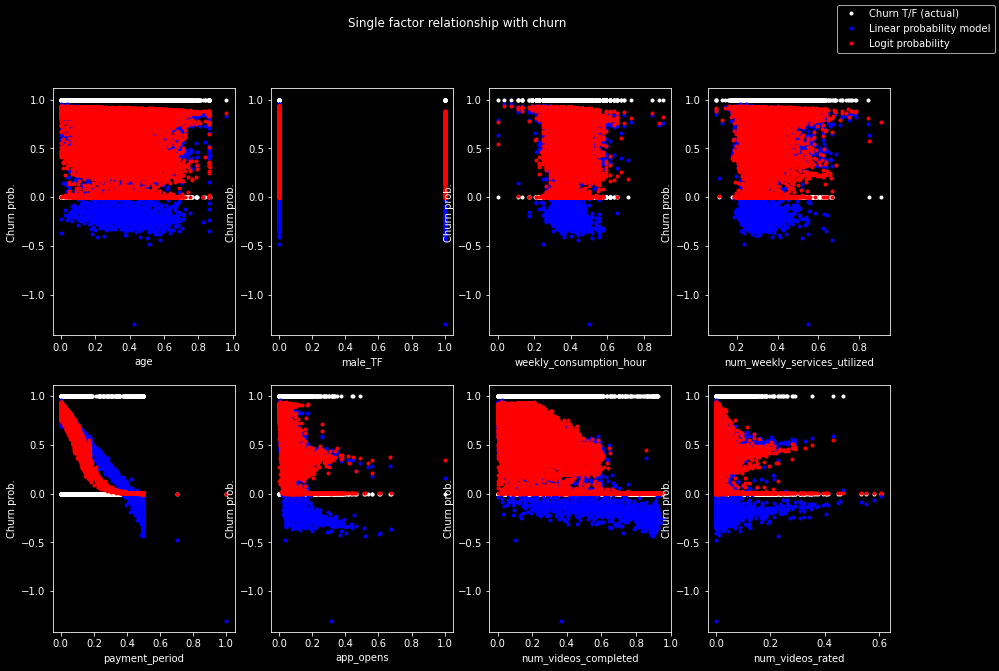

In [171]:


select_plot_coef = [x for x in x_col_name if x != 'const']

n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)

fig, axes = plt.subplots(n_rows, n_cols)
fig.set_size_inches(15,10)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(df_test[select_coef], df_test['churn_TF'], 'w.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')

fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])


plt.savefig('select_plot.png',transparent = True)
plt.show()


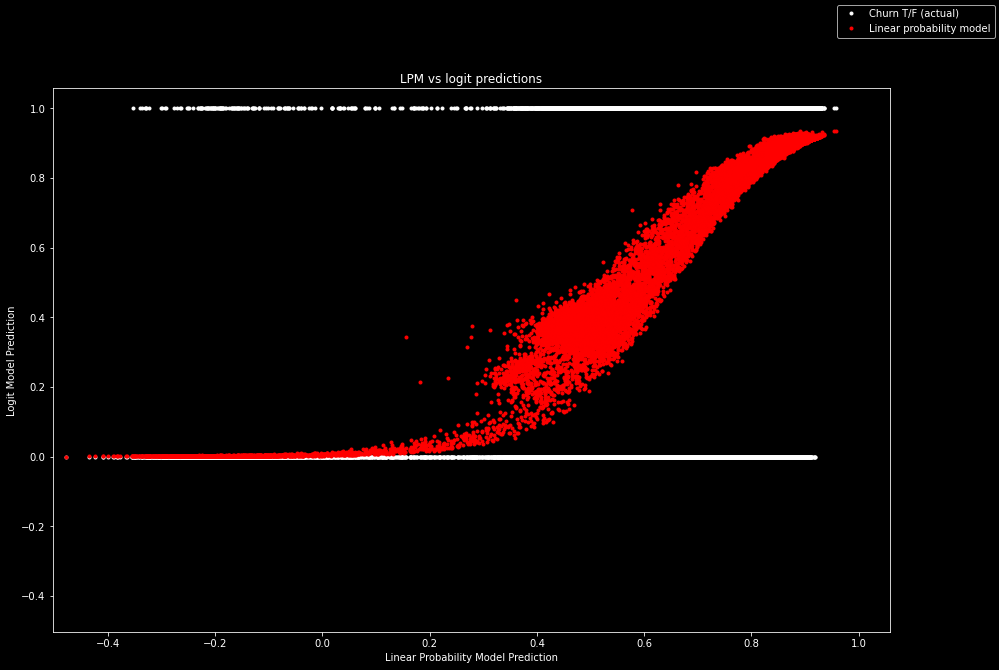

In [174]:
fig = plt.figure()
fig.set_size_inches(15,10)
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn_TF']], 'w.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()+0.8, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+0.1)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

plt.savefig('churn.png',bbox_inches='tight',transparent = True)

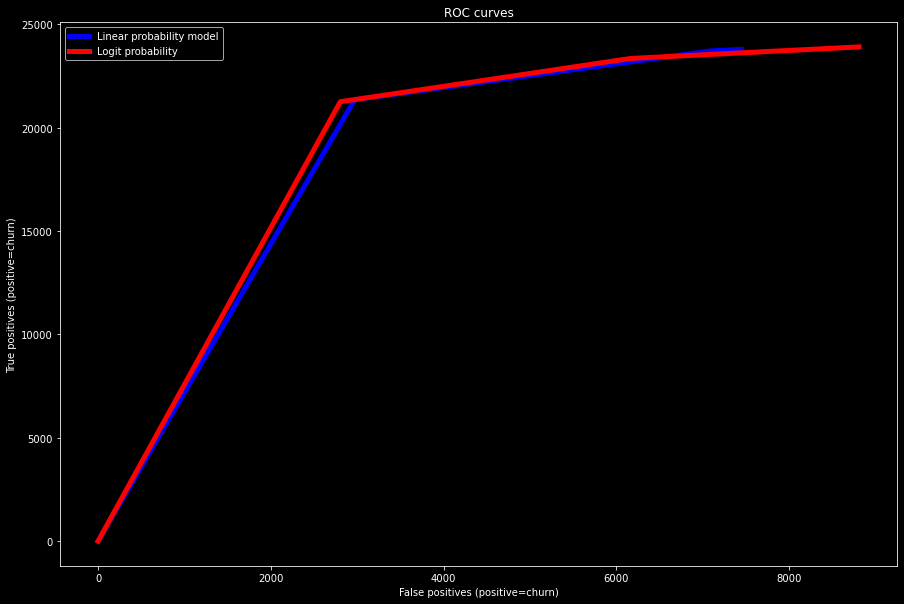

In [188]:
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
fig.set_size_inches(15,10)

ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-',lw=5)
ax1.plot(logit_false_positives, logit_true_positives, 'r-',lw=5)
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

plt.savefig('roc.png',bbox_inches='tight',transparent = True)

In [145]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.4
threshold = 0.7
base_price = 10
discount_amount = 0.4
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    t_discount_amount = t_acceptance_rate_churn
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    t_acceptance_rate_churn = t_discount_amount
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

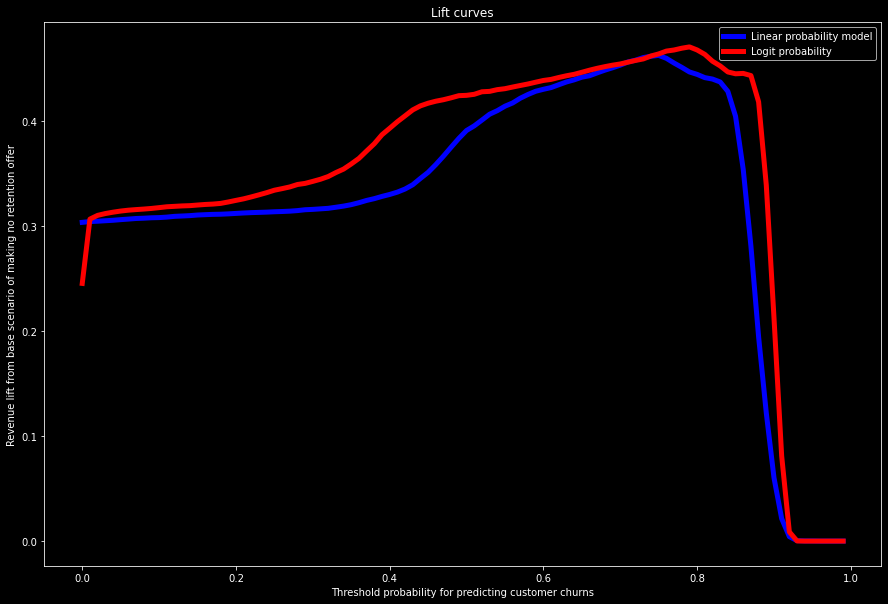

In [186]:
# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
fig.set_size_inches(15,10)

ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-',lw=5)
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-',lw=5)
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

plt.savefig('prob threshold.png',bbox_inches='tight',transparent = True)

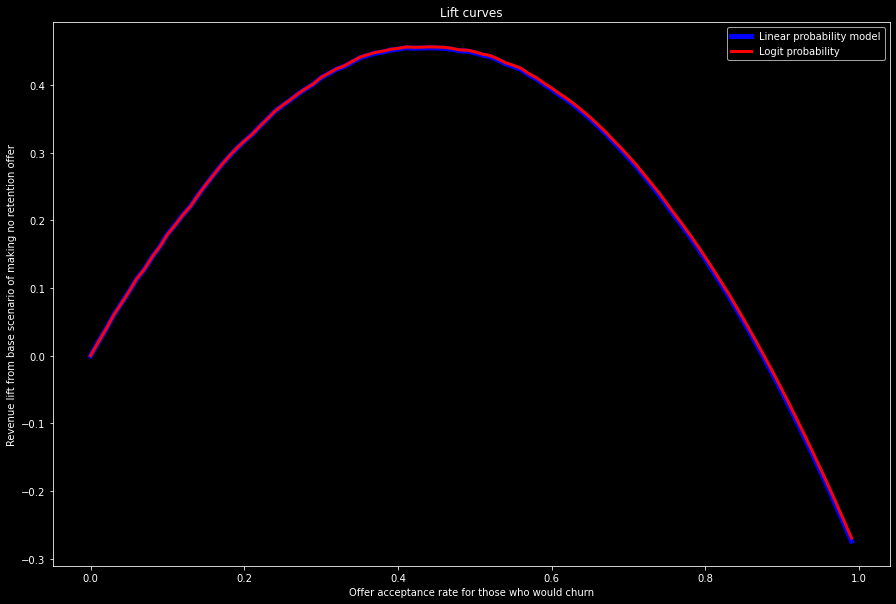

In [184]:
# Acceptance rate sensitivity
fig = plt.figure()
fig.set_size_inches(15,10)

ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-',lw=5)
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-',lw=3)
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

plt.savefig('acceptance rate.png',bbox_inches='tight',transparent = True)

In [90]:
print(df_lift_acceptance_rate_churn['lpm_offer'].max())
print(df_lift_acceptance_rate_churn['logit_offer'].max())

0.3978626560726448
0.4315051078320091


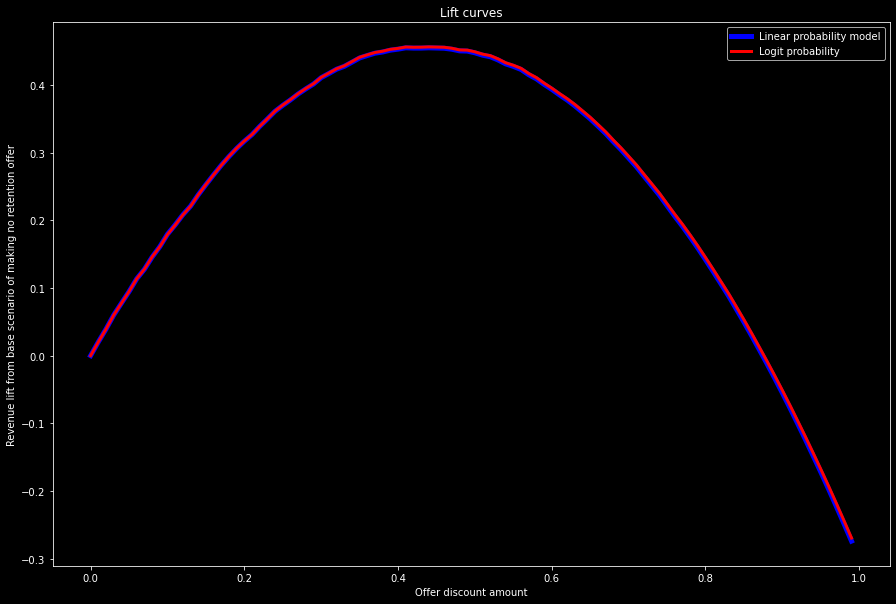

In [189]:
# Discount amount sensitivity
fig = plt.figure()
fig.set_size_inches(15,10)

ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-',lw=5)
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-',lw=3)
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

plt.savefig('discount.png',bbox_inches='tight',transparent = True)